## Contents

### 1. Import Libraries

In [1]:
from textblob import TextBlob
import sys
import tweepy
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os
import re
import string
from wordcloud import WordCloud, STOPWORDS
from PIL import Image

### 2. Data Acquisition

#### 2.1 Connect With the Twitter API

In [2]:
# Authentication 
consumerKey = " "
consumerSecret = " "
accessToken = " "
accessTokenSecret = " "
auth = tweepy.OAuthHandler(consumerKey, consumerSecret)
auth.set_access_token(accessToken, accessTokenSecret)
api = tweepy.API(auth)

#### 2.2 Getting Tweets With Keyword or Hashtags 

The following code were used to get tweets from Twitter API. I saved 5000 tweets which contain the keyword "AirTag" that were posted from May 6th to May 12th, to a CSV file named "resultTweets2".

In [3]:
## Get tweets
keyword = input("Please enter keyword or hashtag to search: ")
noOfTweet = int(input ("Please enter how many tweets to analyze: "))

    # Open/create a file to append data to
#csvFile = open('resultTweets6.csv', 'a')

    #Use csv writer
#csvWriter = csv.writer(csvFile)

#for tweet in tweepy.Cursor(api.search, q = keyword + " -filter:retweets", lang = "en",wait_on_rate_limit=True).items(noOfTweet):

    # Write a row to the CSV file. I use encode UTF-8
#    csvWriter.writerow([tweet.created_at, tweet.text.encode('utf-8','ignore'),tweet.user.location.encode('utf-8','ignore')])
#csvFile.close()

Please enter keyword or hashtag to search: AirTag
Please enter how many tweets to analyze: 5000


#### 2.3 Load Collectd Data

In [4]:
df = pd.read_csv('data/resultTweets2.csv', names=['date','tweet','location'])
df.shape

(5000, 3)

In [5]:
df.head()

,date,tweet,location
0,2021-05-12 22:34:58,b'.@TheTileApp right now:\n\xe2\x80\x9cWe welc...,b''
1,2021-05-12 22:31:00,b'Hahaha @TheTileApp unfollowed @Apple\xe2\x80...,b''
2,2021-05-12 22:26:06,b'@MuseumShuffle @emin_roblack I was thinking ...,"b'Minneapolis, MN'"
3,2021-05-12 22:25:12,b'This is super clever - creating a new batter...,b''
4,2021-05-12 22:14:54,b'Any one be interested if I did an #AirTag gi...,"b'Tyler, TX'"


### 3. Data Cleaning

#### 3.1 Drop Duplicates

In [6]:
# Check the number of duplicated tweets we need to drop
print(df[df.duplicated(keep='first',subset=['tweet'])==True].shape)
# Drop duplicated tweets
df.drop_duplicates(subset=['tweet'],inplace = True)

(18, 3)


18 duplicated tweets were dropped, and we now have 4982 unique tweets left.

#### 3.2 Clean Text

We can see that there are unrelevant words like "b'" in almost every tweets. Besides cleaning those unrelevant words, we also need to clean the links and punctuation characters in all tweets. After that, we will convert all text to lowercase.

In [7]:
# Remove "b'" and 'b"'
df['cleaned_tweet'] = df['tweet'].map(lambda x: re.sub("b'", "",x)).map(lambda x: re.sub('b"', "",x))
# Remove all names mentioned in tweets
df['cleaned_tweet'] = df['cleaned_tweet'].map(lambda x: re.sub(r'@\w+',"", x))
# Remove links in tweets
df['cleaned_tweet'] = df['cleaned_tweet'].map(lambda x: re.sub(r'http\S+',"", x))
# Convert all tweets to lower case
df.cleaned_tweet = df.cleaned_tweet.str.lower()
# Remove unwanted UTF-8 (Bytes) Emoji Code
df['cleaned_tweet'] = df['cleaned_tweet'].map(lambda x: re.sub("[x][0-9a-f]{1,2}","", x))
df.cleaned_tweet = df.cleaned_tweet.map(lambda x: x.replace('\\n',""))
# Remove punctuations
df['cleaned_tweet'] = df['cleaned_tweet'].map(lambda x: re.sub("([^0-9A-Za-z \t])"," ",x))
#.map(lambda x:re.sub('[^A-Za-z0-9 ]+', '', x))
df.head()

,date,tweet,location,cleaned_tweet
0,2021-05-12 22:34:58,b'.@TheTileApp right now:\n\xe2\x80\x9cWe welc...,b'',right now we welcome competition just no...
1,2021-05-12 22:31:00,b'Hahaha @TheTileApp unfollowed @Apple\xe2\x80...,b'',hahaha unfollowed tile a company who was...
2,2021-05-12 22:26:06,b'@MuseumShuffle @emin_roblack I was thinking ...,"b'Minneapolis, MN'",i was thinking it might be in corenfc but i ...
3,2021-05-12 22:25:12,b'This is super clever - creating a new batter...,b'',this is super clever creating a new battery ...
4,2021-05-12 22:14:54,b'Any one be interested if I did an #AirTag gi...,"b'Tyler, TX'",any one be interested if i did an airtag give...


In [8]:
# Drop the original tweet column
df.drop(axis=1,columns=['tweet'],inplace = True)

In [9]:
df.location.value_counts()

b''                        1074
b'United States'            105
b'New York, NY'              61
b'USA'                       46
b'Worldwide'                 44
                           ... 
b'Galveston, TX'              1
b'Groveland, FL'              1
b'Tunisie'                    1
b'elsewhere'                  1
b'45.393804,-75.654402'       1
Name: location, Length: 1718, dtype: int64

In [10]:
# clean the location column
df.location = df.location.replace("b''",np.nan)#.map(lambda x: re.sub('b"', "",x))
df.location = df.location.astype('category')
df.location = df.location.map(lambda x: re.sub("b'", "",x)).map(lambda x: re.sub("'", "",x)).map(lambda x: re.sub('"', "",x))
df.location = df.location.map(lambda x: re.sub("[x][0-9a-f]{1,2}","", x))
df.head()

,date,location,cleaned_tweet
0,2021-05-12 22:34:58,NaN,right now we welcome competition just no...
1,2021-05-12 22:31:00,NaN,hahaha unfollowed tile a company who was...
2,2021-05-12 22:26:06,"Minneapolis, MN",i was thinking it might be in corenfc but i ...
3,2021-05-12 22:25:12,NaN,this is super clever creating a new battery ...
4,2021-05-12 22:14:54,"Tyler, TX",any one be interested if i did an airtag give...


Let's see how these locations distributed by creating a countplot.

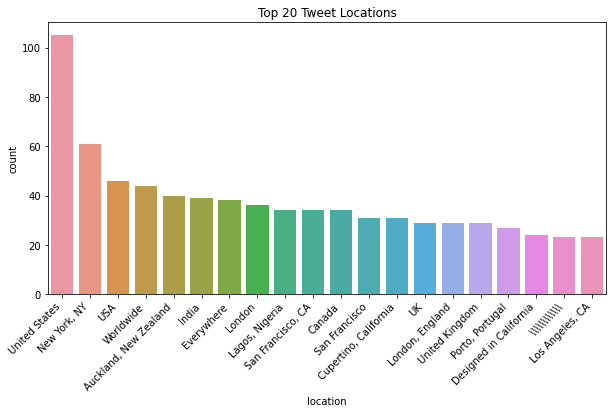

In [11]:
# count plot for locations
plt.figure(figsize=(10,5))
loc_counts = sns.countplot(x = 'location', data = df, order = df['location'].value_counts().head(20).index)
loc_counts = loc_counts.set_xticklabels(loc_counts.get_xticklabels(), rotation = 45, horizontalalignment='right')
plt.title('Top 20 Tweet Locations')
plt.show()

From the above result, we can see that there are too many missing locations or fake location such as "everywhere" and "in your couch". In addition, there's no uniform location format. It would be hard to get any useful information from these locations, so I'm going to drop the location column entirely.

In [12]:
#drop the location column
df.drop('location',axis=1, inplace=True)

### 4. Exploratory Data Analysis

#### 4.1 Sentiment Analysis

TextBlob is a Python (2 and 3) library for processing textual data. It provides a simple API for diving into common natural language processing (NLP) tasks, and I will use it to perform sentiment analysis here.

In [13]:
# Use TextBlob to compute sentiment scores (polarity) and labels

sentiment_scores = [round(TextBlob(tweet).sentiment.polarity, 3) for tweet in df['cleaned_tweet']]
sentiment_category = ['positive' if score > 0 
                             else 'negative' if score < 0 
                                 else 'neutral' 
                                     for score in sentiment_scores]
df['polarity'] = sentiment_scores
df['sentiment'] = sentiment_category
df.head()

,date,cleaned_tweet,polarity,sentiment
0,2021-05-12 22:34:58,right now we welcome competition just no...,0.543,positive
1,2021-05-12 22:31:00,hahaha unfollowed tile a company who was...,0.100,positive
2,2021-05-12 22:26:06,i was thinking it might be in corenfc but i ...,0.000,neutral
3,2021-05-12 22:25:12,this is super clever creating a new battery ...,0.187,positive
4,2021-05-12 22:14:54,any one be interested if i did an airtag give...,0.250,positive


In [14]:
df.sentiment.value_counts()

neutral     2190
positive    2087
negative     705
Name: sentiment, dtype: int64

We can split the dataframe df into 3 groups based on sentiment.

In [15]:
#Creating new data frames for all sentiments (positive, negative and neutral)
tw_negative = df[df["sentiment"]=="negative"]
tw_positive = df[df["sentiment"]=="positive"]
tw_neutral  = df[df["sentiment"]=="neutral"]

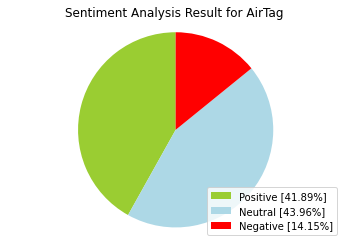

In [16]:
# Create a pie chart for sentiment components
pos_pct = round(100 * tw_positive.shape[0]/df.shape[0],2)
neu_pct = round(100 * tw_neutral.shape[0]/df.shape[0],2)
neg_pct = round(100 * tw_negative.shape[0]/df.shape[0],2)
labels = ['Positive ['+str(pos_pct)+'%]' , 'Neutral ['+str(neu_pct)+'%]','Negative ['+str(neg_pct)+'%]']
sizes = [pos_pct, neu_pct, neg_pct]
colors = ['yellowgreen', 'lightblue','red']
patches, texts = plt.pie(sizes,colors=colors, startangle=90)
plt.style.use('default')
plt.legend(labels)
plt.title("Sentiment Analysis Result for "+keyword+"" )
plt.axis('equal')
plt.show()

With 41.89% of positive tweets, 43.96% of neutral tweets, and only 14.15% of negative tweets, we can see that the general perception of AirTAG was not bad at all. 

#### 4.2 Keywords by Sentiments

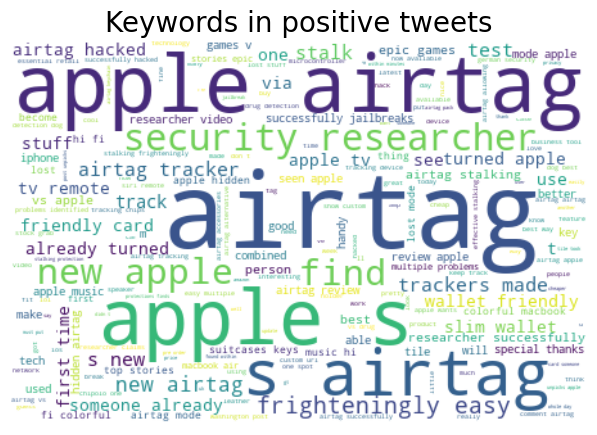

In [17]:
# Generate a word cloud for tweets with positive sentiment
pos_text = " ".join(text for text in tw_positive['cleaned_tweet'].str.lower())
stopwords = set(STOPWORDS)
# Generate a word cloud image
wordcloud = WordCloud(width=450,height= 300,stopwords=stopwords, background_color="white").generate(pos_text)
# Display the generated image:
plt.figure(figsize=(10,5))
plt.title('Keywords in positive tweets',fontsize=20)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

According to the word cloud above, some common words for for tweets with postive sentiment include but not limit to "wallet friendly", "security researcher", "new", "friendly card", "frightening easy", and "find". 

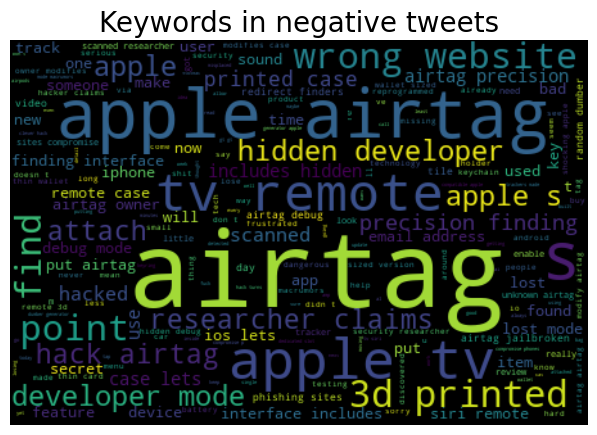

In [18]:
# Generate a word cloud for tweets with negative sentiment
neg_text = " ".join(text for text in tw_negative['cleaned_tweet'].str.lower())
stopwords = set(STOPWORDS)
# Generate a word cloud image
wordcloud = WordCloud(width=450,height= 300,stopwords=stopwords).generate(neg_text)
# Display the generated image:
plt.figure(figsize=(10,5))
plt.title('Keywords in negative tweets',fontsize=20)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

From the word cloud for tweets with negative sentiment, we can spot some words like "wrong website", "hidden developer", "3d printed", "hack airtag", and "tv remote". It's not easy to tell what's going on from these keywords, but we can dive deeper into it later.

Now we will see the density of words used in tweets based on different sentiment by calculating the tweet length and word count.

In [19]:
#Calculating tweet's lenght and word count
df['text_len'] = df['cleaned_tweet'].astype(str).apply(len)
df['text_word_count'] = df['cleaned_tweet'].apply(lambda x: len(str(x).split()))
pd.DataFrame(df.groupby("sentiment").text_word_count.mean())

,text_word_count
sentiment,
negative,15.442553
neutral,11.946119
positive,15.165309


In [20]:
df['text_word_count'].describe()

count    4982.000000
mean       13.789442
std         5.740912
min         0.000000
25%        10.000000
50%        13.000000
75%        18.000000
max        29.000000
Name: text_word_count, dtype: float64

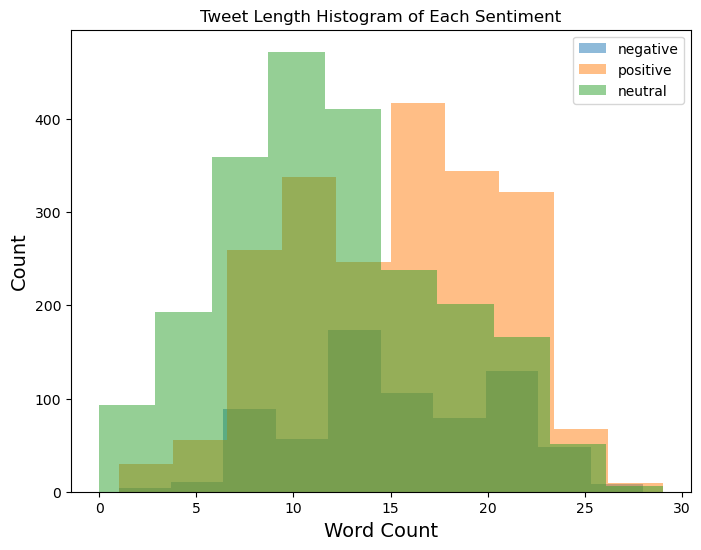

In [21]:
plt.figure(figsize=(8,6))
plt.hist(df[df["sentiment"]=="negative"]['text_word_count'],alpha=0.5,label="negative")
plt.hist(df[df["sentiment"]=="positive"]['text_word_count'],alpha=0.5,label="positive")
plt.hist(df[df["sentiment"]=="neutral"]['text_word_count'],alpha=0.5,label="neutral")
plt.xlabel("Word Count", size=14)
plt.ylabel("Count", size=14)
plt.title('Tweet Length Histogram of Each Sentiment')
plt.legend(loc='upper right')
plt.show()

# consider stacked histogram

It seems like tweets that are neutral are usually shorter, and the tweets with positive or negative emotion are generally longer. It's probabaly becuase people tend to have more to say or use more expressions when they have stronger reaction to a product.

#### 4.3 Emotion Trends

Next, I am going to create a line chart and see how the polarity score changed in the week of 5/6 - 5/12.

In [22]:
# Convert 'date' to datetime objects and only keep the dates
df.date = pd.to_datetime(df.date).dt.date
# group data by date
df_date = df.groupby('date')

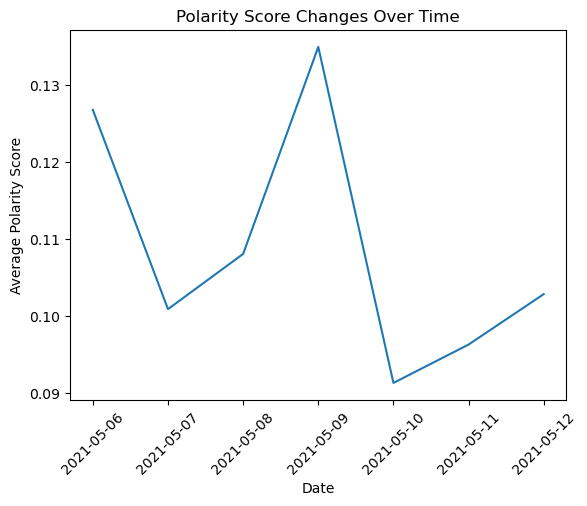

In [23]:
# See how the average polarity score changes
avg_polarity = df_date.mean()['polarity']
polarity_line = plt.plot(avg_polarity.index, avg_polarity.values)
plt.xticks(rotation=45)
plt.title("Polarity Score Changes Over Time")
plt.xlabel('Date')
plt.ylabel('Average Polarity Score')
plt.show()

This curve illustrates that the average polarity score went up and down in the 2nd week after AirTag was released. It arrived at its peak on May 9th with an average polarity score that's higher than 0.13, but then it jumped to its lowest point on the next day with a score of 0.09. However, the changes were not huge, and the overall sentiment was positive at all time.

### 5. Save Data

In [24]:
# Save data for the next step
datapath = 'data'
datapath_cleaned = os.path.join(datapath, 'cleaned_tweets.csv')
if not os.path.exists(datapath_cleaned):
    df.to_csv(datapath_cleaned, index=False)